# 베스트셀러 순위 급등/급락 분석

## 목적
- 전주 대비 순위가 급격히 변동하는 케이스 분석
- 관성을 깨는 요인이 무엇인지 파악
- 바이럴 지수, 뉴스 등 외부 요인과의 관계 분석

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from dotenv import load_dotenv
from supabase import create_client

plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False

load_dotenv()

# Supabase 연결
supabase = create_client(
    os.getenv("SUPABASE_URL"),
    os.getenv("SUPABASE_KEY")
)
print("Supabase 연결 완료")

Supabase 연결 완료


## 1. 데이터 로드

In [2]:
# weekly_bestsellers 테이블에서 데이터 가져오기
response = supabase.table('weekly_bestsellers').select('*').execute()
df_bestseller = pd.DataFrame(response.data)
print(f"베스트셀러 데이터: {len(df_bestseller)}행")
df_bestseller.head()

베스트셀러 데이터: 1000행


,id,bestseller_week,rank,product_code,rating,review_count,created_at,ymw
0,450,2025.01.29 ~ 2025.02.04,1,S000215067855,9.19,273,2026-01-20T02:27:34.740855+00:00,2025021
1,451,2025.01.29 ~ 2025.02.04,2,S000214710919,9.82,415,2026-01-20T02:27:34.740855+00:00,2025021
2,452,2025.01.29 ~ 2025.02.04,3,S000214208202,9.62,607,2026-01-20T02:27:34.740855+00:00,2025021
3,453,2025.01.29 ~ 2025.02.04,4,S000214357841,9.78,186,2026-01-20T02:27:34.740855+00:00,2025021
4,454,2025.01.29 ~ 2025.02.04,5,S000001947552,9.65,1592,2026-01-20T02:27:34.740855+00:00,2025021


In [3]:
# books 테이블에서 책 제목 가져오기
response = supabase.table('books').select('product_code, title').execute()
df_books_title = pd.DataFrame(response.data)
print(f"books 테이블: {len(df_books_title)}행")

# books_with_tags_variables에서 카테고리 가져오기
response = supabase.table('books_with_tags_variables').select('product_code, category_1, category_2, category_3, category_4, category_5, category_6, category_7, category_8, category_9, category_10').execute()
df_books_cat = pd.DataFrame(response.data)
print(f"books_with_tags_variables 테이블: {len(df_books_cat)}행")

# 카테고리 추출
category_cols = [f'category_{i}' for i in range(1, 11)]
category_names = ['거시경제/금융정책', '경제이론/학술', '금융시스템/위기', '기업/비즈니스', 
                  '부동산/실물자산', '재테크/개인금융', '주식/투자매매', '지정학/세계경제', 
                  '창업/스타트업/기술', '투자철학/심리']

def get_main_category(row):
    vals = [row[c] for c in category_cols]
    max_idx = vals.index(max(vals))
    return category_names[max_idx]

if len(df_books_cat) > 0:
    df_books_cat['category'] = df_books_cat.apply(get_main_category, axis=1)
    df_books_cat = df_books_cat[['product_code', 'category']]

# 병합
df_books = df_books_title.merge(df_books_cat, on='product_code', how='left')
print(f"병합된 책 정보: {len(df_books)}행")
print(f"카테고리 있는 책: {df_books['category'].notna().sum()}개")

books 테이블: 515행


books_with_tags_variables 테이블: 1000행
병합된 책 정보: 1493행
카테고리 있는 책: 1000개


In [4]:
# 데이터 병합
df = df_bestseller.merge(df_books, on='product_code', how='left')
df = df.sort_values(['product_code', 'ymw'])
print(f"병합된 데이터: {len(df)}행")
print(f"\n컬럼: {df.columns.tolist()}")
print(f"\nymw 범위: {df['ymw'].min()} ~ {df['ymw'].max()}")
print(f"고유 책 수: {df['product_code'].nunique()}")
print(f"고유 주간 수: {df['ymw'].nunique()}")

병합된 데이터: 15772행

컬럼: ['id', 'bestseller_week', 'rank', 'product_code', 'rating', 'review_count', 'created_at', 'ymw', 'title', 'category']

ymw 범위: 2025012 ~ 2025124
고유 책 수: 146
고유 주간 수: 51


## 2. 순위 변동 계산

In [5]:
# ymw를 정렬 가능한 형태로 변환
df['ymw'] = df['ymw'].astype(str)
df = df.sort_values(['ymw', 'rank'])

# 주간 목록 정렬
weeks = sorted(df['ymw'].unique())
print(f"주간 목록 ({len(weeks)}개): {weeks[:5]} ... {weeks[-5:]}")

주간 목록 (51개): ['2025012', '2025013', '2025014', '2025021', '2025022'] ... ['2025115', '2025121', '2025122', '2025123', '2025124']


In [6]:
# 전주 순위 계산 (같은 책의 이전 주 순위)
week_to_idx = {w: i for i, w in enumerate(weeks)}
idx_to_week = {i: w for w, i in week_to_idx.items()}

# 각 주간별 책-순위 매핑
week_rank_map = df.groupby('ymw').apply(
    lambda x: dict(zip(x['product_code'], x['rank']))
).to_dict()

# 전주 순위 추가
def get_prev_rank(row):
    current_week = row['ymw']
    current_idx = week_to_idx.get(current_week, 0)
    if current_idx == 0:
        return None
    prev_week = idx_to_week.get(current_idx - 1)
    if prev_week is None:
        return None
    return week_rank_map.get(prev_week, {}).get(row['product_code'], None)

df['prev_rank'] = df.apply(get_prev_rank, axis=1)
df['rank_change'] = df['prev_rank'] - df['rank']  # 양수 = 상승, 음수 = 하락

print(f"전주 순위 있는 데이터: {df['prev_rank'].notna().sum()}행")
df[['ymw', 'rank', 'prev_rank', 'rank_change', 'title']].head(10)

전주 순위 있는 데이터: 14246행


/var/folders/hp/lh0q6l5n46l5l7ls7k1ds85h0000gn/T/ipykernel_66055/4286080278.py:6: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  week_rank_map = df.groupby('ymw').apply(


,ymw,rank,prev_rank,rank_change,title
3492,2025012,1,NaN,NaN,트렌드 코리아 2025
3493,2025012,1,NaN,NaN,트렌드 코리아 2025
3494,2025012,1,NaN,NaN,트렌드 코리아 2025
3495,2025012,1,NaN,NaN,트렌드 코리아 2025
3496,2025012,1,NaN,NaN,트렌드 코리아 2025
3497,2025012,1,NaN,NaN,트렌드 코리아 2025
3498,2025012,1,NaN,NaN,트렌드 코리아 2025
3499,2025012,1,NaN,NaN,트렌드 코리아 2025
3500,2025012,1,NaN,NaN,트렌드 코리아 2025
3501,2025012,1,NaN,NaN,트렌드 코리아 2025


## 3. 급등/급락 정의 및 분류

In [7]:
# 급등/급락 기준: 5단계 이상 변동
THRESHOLD = 5

df_with_change = df[df['rank_change'].notna()].copy()

# 케이스 분류
df_with_change['case_type'] = 'normal'
df_with_change.loc[df_with_change['rank_change'] >= THRESHOLD, 'case_type'] = 'surge'  # 급등
df_with_change.loc[df_with_change['rank_change'] <= -THRESHOLD, 'case_type'] = 'drop'  # 급락

# 신규 진입 (전주 순위 없음 = 20위 밖이었음)
df_new_entry = df[df['prev_rank'].isna() & (df['ymw'] != weeks[0])].copy()
df_new_entry['case_type'] = 'new_entry'

print("=== 케이스 분류 ===")
print(f"급등 (5단계↑): {(df_with_change['case_type'] == 'surge').sum()}건")
print(f"급락 (5단계↓): {(df_with_change['case_type'] == 'drop').sum()}건")
print(f"일반: {(df_with_change['case_type'] == 'normal').sum()}건")
print(f"신규 진입: {len(df_new_entry)}건")

=== 케이스 분류 ===
급등 (5단계↑): 315건
급락 (5단계↓): 473건
일반: 13458건
신규 진입: 952건


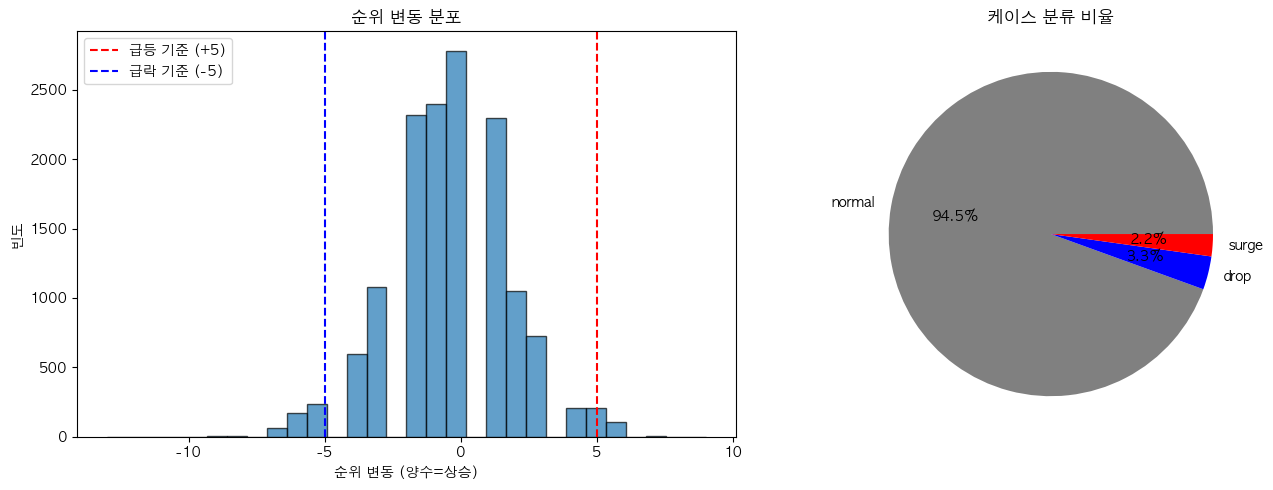

In [8]:
# 순위 변동 분포
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 히스토그램
axes[0].hist(df_with_change['rank_change'], bins=30, edgecolor='black', alpha=0.7)
axes[0].axvline(x=THRESHOLD, color='red', linestyle='--', label=f'급등 기준 (+{THRESHOLD})')
axes[0].axvline(x=-THRESHOLD, color='blue', linestyle='--', label=f'급락 기준 (-{THRESHOLD})')
axes[0].set_xlabel('순위 변동 (양수=상승)')
axes[0].set_ylabel('빈도')
axes[0].set_title('순위 변동 분포')
axes[0].legend()

# 케이스별 비율
case_counts = df_with_change['case_type'].value_counts()
colors = {'surge': 'red', 'drop': 'blue', 'normal': 'gray'}
axes[1].pie(case_counts, labels=case_counts.index, autopct='%1.1f%%', 
            colors=[colors.get(c, 'gray') for c in case_counts.index])
axes[1].set_title('케이스 분류 비율')

plt.tight_layout()
plt.savefig('rank_change_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

## 4. 바이럴 지수 데이터 로드

In [9]:
# 바이럴 지수 로드 (revised 버전 - 시점 맞춤)
df_viral = pd.read_csv('../weekly_news_viral_index_revised.csv')
df_viral['ymw'] = df_viral['ymw'].astype(str)
print(f"바이럴 지수 데이터 (revised): {len(df_viral)}행")
print(f"ymw 범위: {df_viral['ymw'].min()} ~ {df_viral['ymw'].max()}")
df_viral.head()

바이럴 지수 데이터 (revised): 550행
ymw 범위: 2025012 ~ 2025123


,ymw,bestseller_week,category,viral_index,viral_index_smoothed,article_count,start_date,end_date
0,2025012,2025.01.08 ~ 2025.01.14,부동산/실물자산,5.970913,5.970913,566,2025-01-08,2025-01-14
1,2025012,2025.01.08 ~ 2025.01.14,기업경영/리더십,6.000000,6.000000,1007,2025-01-08,2025-01-14
2,2025012,2025.01.08 ~ 2025.01.14,주식투자/트레이딩,3.969871,3.969871,593,2025-01-08,2025-01-14
3,2025012,2025.01.08 ~ 2025.01.14,테크/스타트업,5.690823,5.690823,518,2025-01-08,2025-01-14
4,2025012,2025.01.08 ~ 2025.01.14,재테크/개인금융,4.285352,4.285352,53,2025-01-08,2025-01-14


In [10]:
# 카테고리별 바이럴 지수를 wide format으로 변환
df_viral_wide = df_viral.pivot(index='ymw', columns='category', values='viral_index').reset_index()
df_viral_wide.columns.name = None
print(f"바이럴 지수 (wide): {df_viral_wide.shape}")
df_viral_wide.head()

바이럴 지수 (wide): (50, 12)


,ymw,거시경제/금융정책,경제이론/학술,금융시스템/위기,기업경영/리더십,미분류,부동산/실물자산,재테크/개인금융,주식투자/트레이딩,지정학/국제정세,테크/스타트업,투자철학/대가
0,2025012,6.000000,5.500533,3.600349,6.000000,5.962935,5.970913,4.285352,3.969871,2.329679,5.690823,1.109913
1,2025013,-45.080630,-51.815906,-42.685083,-58.561155,-36.604991,-50.571022,-63.824070,-42.226274,-42.182767,-56.869834,-46.580297
2,2025014,-37.130904,-22.771940,-26.960272,-32.630617,-44.639831,-27.127253,-20.898626,-34.715961,-40.576430,-17.351199,-6.657441
3,2025021,47.935293,-9.191866,72.140748,21.245588,6.869396,0.620138,55.736541,25.947686,105.251795,27.899675,84.210458
4,2025022,-23.775271,9.945581,-58.513426,1.606397,34.991968,6.018554,36.729624,10.987673,3.622425,13.508259,-30.482415


## 5. 급등/급락 케이스와 바이럴 지수 비교

In [11]:
# 책의 카테고리와 해당 카테고리의 바이럴 지수 매칭
# 먼저 카테고리 정보 확인
print("카테고리 분포:")
print(df_with_change['category'].value_counts())

카테고리 분포:
category
주식/투자매매       3898
투자철학/심리       3468
기업/비즈니스       2346
경제이론/학술       2193
재테크/개인금융      1020
거시경제/금융정책      612
창업/스타트업/기술     153
Name: count, dtype: int64


In [12]:
# 전체 바이럴 지수 평균 계산 + Lag 적용
df_viral_avg = df_viral.groupby('ymw')['viral_index'].mean().reset_index()
df_viral_avg.columns = ['ymw', 'avg_viral_index']
df_viral_avg = df_viral_avg.sort_values('ymw')

# Lag 컬럼 추가 (1주 전, 2주 전 바이럴 지수)
df_viral_avg['viral_lag1'] = df_viral_avg['avg_viral_index'].shift(1)
df_viral_avg['viral_lag2'] = df_viral_avg['avg_viral_index'].shift(2)

print("바이럴 지수 + Lag:")
print(df_viral_avg.head(10))

# 병합
df_analysis = df_with_change.merge(df_viral_avg, on='ymw', how='left')
print(f"\n분석 데이터: {len(df_analysis)}행")
print(f"Lag1 있는 데이터: {df_analysis['viral_lag1'].notna().sum()}행")
print(f"Lag2 있는 데이터: {df_analysis['viral_lag2'].notna().sum()}행")

바이럴 지수 + Lag:
       ymw  avg_viral_index  viral_lag1  viral_lag2
0  2025012         4.583670         NaN         NaN
1  2025013       -48.818366    4.583670         NaN
2  2025014       -28.314588  -48.818366    4.583670
3  2025021        39.878678  -28.314588  -48.818366
4  2025022         0.421761   39.878678  -28.314588
5  2025023       -16.716465    0.421761   39.878678
6  2025024         0.183664  -16.716465    0.421761
7  2025031       112.542458    0.183664  -16.716465
8  2025032       -75.896285  112.542458    0.183664
9  2025033       117.517039  -75.896285  112.542458

분석 데이터: 14246행
Lag1 있는 데이터: 14079행
Lag2 있는 데이터: 13507행


In [13]:
# 케이스별 바이럴 지수 비교 (동시점 + Lag1 + Lag2)
print("=== 케이스별 바이럴 지수 비교 ===\n")

# 동시점
print("[동시점 바이럴 지수]")
viral_by_case = df_analysis.groupby('case_type')['avg_viral_index'].agg(['mean', 'std', 'count'])
print(viral_by_case.round(2))

# Lag1 (1주 전 바이럴 → 이번 주 순위 변동)
print("\n[1주 전 바이럴 지수 (Lag1)]")
viral_lag1_by_case = df_analysis.groupby('case_type')['viral_lag1'].agg(['mean', 'std', 'count'])
print(viral_lag1_by_case.round(2))

# Lag2 (2주 전 바이럴 → 이번 주 순위 변동)
print("\n[2주 전 바이럴 지수 (Lag2)]")
viral_lag2_by_case = df_analysis.groupby('case_type')['viral_lag2'].agg(['mean', 'std', 'count'])
print(viral_lag2_by_case.round(2))

=== 케이스별 바이럴 지수 비교 ===

[동시점 바이럴 지수]
            mean    std  count
case_type                     
drop       34.63  43.86    473
normal     13.10  57.76  13291
surge      -0.80  50.09    315

[1주 전 바이럴 지수 (Lag1)]
            mean    std  count
case_type                     
drop       41.74  59.39    473
normal      9.99  53.76  13291
surge      35.68  40.84    315

[2주 전 바이럴 지수 (Lag2)]
            mean    std  count
case_type                     
drop        4.79  61.28    473
normal     13.40  52.44  12720
surge      30.57  66.99    314


/var/folders/hp/lh0q6l5n46l5l7ls7k1ds85h0000gn/T/ipykernel_66055/3131200028.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_to_plot, labels=case_labels, patch_artist=True)


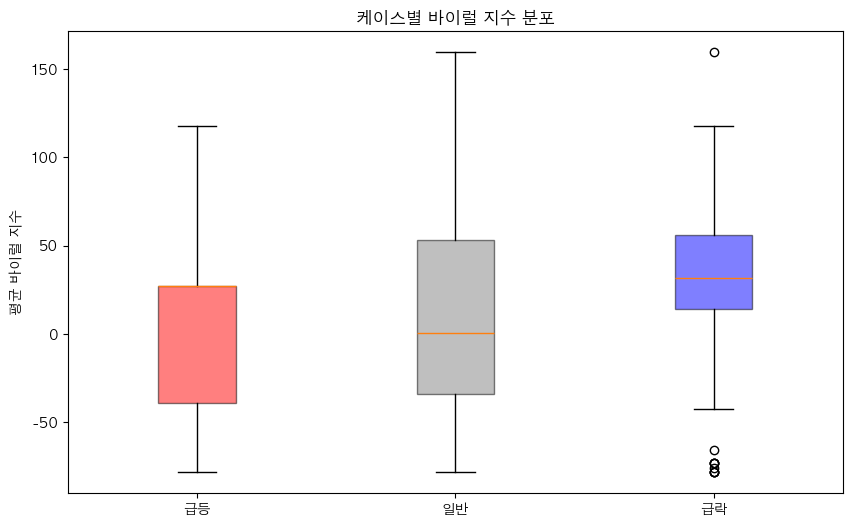

In [14]:
# 시각화: 케이스별 바이럴 지수 분포
fig, ax = plt.subplots(figsize=(10, 6))

case_types = ['surge', 'normal', 'drop']
case_labels = ['급등', '일반', '급락']
colors = ['red', 'gray', 'blue']

data_to_plot = [df_analysis[df_analysis['case_type'] == ct]['avg_viral_index'].dropna() 
                for ct in case_types]

bp = ax.boxplot(data_to_plot, labels=case_labels, patch_artist=True)
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.5)

ax.set_ylabel('평균 바이럴 지수')
ax.set_title('케이스별 바이럴 지수 분포')
plt.savefig('viral_index_by_case.png', dpi=150, bbox_inches='tight')
plt.show()

In [15]:
# 통계적 검정: 급등 vs 일반 (동시점 + Lag1 + Lag2)
from scipy import stats

print("=== t-test 결과 ===\n")

for col, label in [('avg_viral_index', '동시점'), ('viral_lag1', 'Lag1 (1주전)'), ('viral_lag2', 'Lag2 (2주전)')]:
    surge = df_analysis[df_analysis['case_type'] == 'surge'][col].dropna()
    normal = df_analysis[df_analysis['case_type'] == 'normal'][col].dropna()
    drop = df_analysis[df_analysis['case_type'] == 'drop'][col].dropna()
    
    print(f"[{label}]")
    if len(surge) > 0 and len(normal) > 0:
        t_stat, p_value = stats.ttest_ind(surge, normal)
        sig = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else ""
        print(f"  급등 vs 일반: t={t_stat:.3f}, p={p_value:.4f} {sig}")
        print(f"  급등 평균: {surge.mean():.2f}, 일반 평균: {normal.mean():.2f}")
    
    if len(drop) > 0 and len(normal) > 0:
        t_stat, p_value = stats.ttest_ind(drop, normal)
        sig = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else ""
        print(f"  급락 vs 일반: t={t_stat:.3f}, p={p_value:.4f} {sig}")
        print(f"  급락 평균: {drop.mean():.2f}, 일반 평균: {normal.mean():.2f}")
    print()

=== t-test 결과 ===

[동시점]
  급등 vs 일반: t=-4.231, p=0.0000 ***
  급등 평균: -0.80, 일반 평균: 13.10
  급락 vs 일반: t=8.025, p=0.0000 ***
  급락 평균: 34.63, 일반 평균: 13.10

[Lag1 (1주전)]
  급등 vs 일반: t=8.425, p=0.0000 ***
  급등 평균: 35.68, 일반 평균: 9.99
  급락 vs 일반: t=12.573, p=0.0000 ***
  급락 평균: 41.74, 일반 평균: 9.99

[Lag2 (2주전)]
  급등 vs 일반: t=5.689, p=0.0000 ***
  급등 평균: 30.57, 일반 평균: 13.40
  급락 vs 일반: t=-3.486, p=0.0005 ***
  급락 평균: 4.79, 일반 평균: 13.40



## 6. 카테고리별 급등/급락 분석

In [16]:
# 카테고리별 급등/급락 빈도
category_case = pd.crosstab(df_analysis['category'], df_analysis['case_type'], normalize='index') * 100
category_case = category_case.sort_values('surge', ascending=False)
print("=== 카테고리별 급등/급락 비율 (%) ===")
print(category_case.round(1))

=== 카테고리별 급등/급락 비율 (%) ===
case_type   drop  normal  surge
category                       
기업/비즈니스      6.5    89.1    4.3
투자철학/심리      0.0    97.1    2.9
경제이론/학술      2.3    95.3    2.3
주식/투자매매      3.9    94.8    1.3
거시경제/금융정책    8.3    91.7    0.0
재테크/개인금융     0.0   100.0    0.0
창업/스타트업/기술   0.0   100.0    0.0


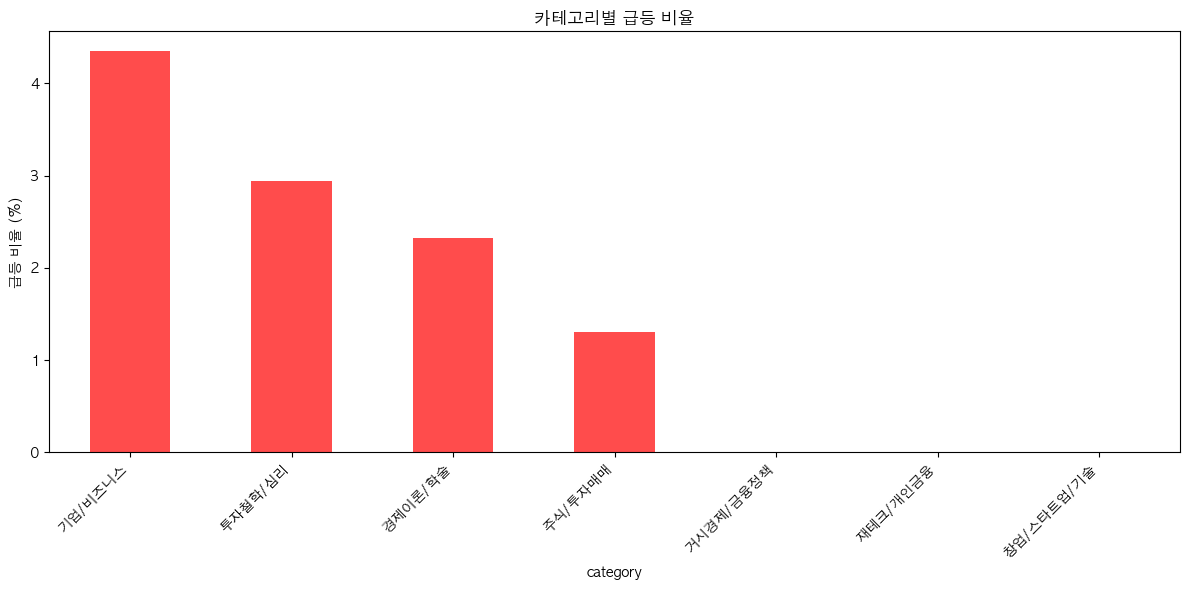

In [17]:
# 카테고리별 급등 비율 시각화
if 'surge' in category_case.columns:
    fig, ax = plt.subplots(figsize=(12, 6))
    category_case['surge'].plot(kind='bar', ax=ax, color='red', alpha=0.7)
    ax.set_ylabel('급등 비율 (%)')
    ax.set_title('카테고리별 급등 비율')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig('surge_ratio_by_category.png', dpi=150, bbox_inches='tight')
    plt.show()

## 7. 급등 케이스 상세 분석

In [18]:
# 급등 케이스 상세
df_surge = df_analysis[df_analysis['case_type'] == 'surge'].copy()
df_surge = df_surge.sort_values('rank_change', ascending=False)

print(f"=== 급등 케이스 TOP 10 ===")
display_cols = ['ymw', 'title', 'category', 'prev_rank', 'rank', 'rank_change', 'avg_viral_index']
available_cols = [c for c in display_cols if c in df_surge.columns]
print(df_surge[available_cols].head(10).to_string())

=== 급등 케이스 TOP 10 ===
          ymw                     title category  prev_rank  rank  rank_change  avg_viral_index
5359  2025041             실리콘밸리 프로세스의 힘      NaN       15.0     6          9.0        73.112715
52    2025013             왜 그들만 부자가 되는가      NaN       10.0     3          7.0       -48.818366
5414  2025041        단 3개의 미국 ETF로 은퇴하라      NaN       18.0    11          7.0        73.112715
9849  2025072        결핍은 우리를 어떻게 변화시키는가      NaN       18.0    11          7.0       -20.264492
9797  2025072  돈의 심리학(30만 부 기념 스페셜 에디션)  주식/투자매매       13.0     7          6.0       -20.264492
9834  2025072  돈의 심리학(30만 부 기념 스페셜 에디션)  주식/투자매매       13.0     7          6.0       -20.264492
9824  2025072  돈의 심리학(30만 부 기념 스페셜 에디션)  주식/투자매매       13.0     7          6.0       -20.264492
9825  2025072  돈의 심리학(30만 부 기념 스페셜 에디션)  주식/투자매매       13.0     7          6.0       -20.264492
9826  2025072  돈의 심리학(30만 부 기념 스페셜 에디션)  주식/투자매매       13.0     7          6.0       -20.264492
9827  2025072  돈의 

In [19]:
# 급락 케이스 상세
df_drop = df_analysis[df_analysis['case_type'] == 'drop'].copy()
df_drop = df_drop.sort_values('rank_change', ascending=True)

print(f"=== 급락 케이스 TOP 10 ===")
print(df_drop[available_cols].head(10).to_string())

=== 급락 케이스 TOP 10 ===
           ymw                 title category  prev_rank  rank  rank_change  avg_viral_index
4470   2025033                베스트 옵션      NaN        4.0    17        -13.0       117.517039
11151  2025084       글로벌 주식 투자 빅 시프트      NaN        9.0    20        -11.0       -42.186148
11893  2025101  다시 쓰는 대한민국 부동산 사용설명서      NaN        6.0    16        -10.0        34.204639
2086   2025022             알트코인 레볼루션      NaN       10.0    19         -9.0         0.421761
12328  2025103                한국의 미래      NaN       10.0    19         -9.0        39.573991
4000   2025032            일하는 사장의 생각      NaN        7.0    16         -9.0       -75.896285
14077  2025123         대형주 추세추종 투자법칙      NaN       11.0    19         -8.0       159.538104
5987   2025042     트럼프 시대의 지정학과 비트코인      NaN        9.0    17         -8.0       -41.816107
6039   2025042       플팩의 상급지로 가는 대출력      NaN       12.0    20         -8.0       -41.816107
3017   2025024                미지의 늑대      NaN   

## 8. 신규 진입 케이스 분석

In [20]:
# 신규 진입 케이스
df_new = df_new_entry.merge(df_viral_avg, on='ymw', how='left')
df_new = df_new.merge(df_books[['product_code', 'category']], on='product_code', how='left', suffixes=('', '_book'))

print(f"=== 신규 진입 케이스: {len(df_new)}건 ===")
if len(df_new) > 0:
    print(f"\n평균 진입 순위: {df_new['rank'].mean():.1f}")
    print(f"평균 바이럴 지수: {df_new['avg_viral_index'].mean():.2f}")
    
    # 비교: 기존 책의 평균 바이럴 지수
    existing_viral = df_analysis[df_analysis['case_type'] == 'normal']['avg_viral_index'].mean()
    print(f"일반 케이스 평균 바이럴 지수: {existing_viral:.2f}")

=== 신규 진입 케이스: 41754건 ===

평균 진입 순위: 15.7
평균 바이럴 지수: 19.86


일반 케이스 평균 바이럴 지수: 13.10


## 9. 결론 및 인사이트

In [21]:
# 결과 요약
print("="*60)
print("급등/급락 케이스 분석 결과 요약")
print("="*60)

total = len(df_with_change)
surge_count = (df_with_change['case_type'] == 'surge').sum()
drop_count = (df_with_change['case_type'] == 'drop').sum()
normal_count = (df_with_change['case_type'] == 'normal').sum()

print(f"\n[케이스 분포]")
print(f"- 급등 (5단계↑): {surge_count}건 ({surge_count/total*100:.1f}%)")
print(f"- 급락 (5단계↓): {drop_count}건 ({drop_count/total*100:.1f}%)")
print(f"- 일반: {normal_count}건 ({normal_count/total*100:.1f}%)")
print(f"- 신규 진입: {len(df_new_entry)}건")

print(f"\n[바이럴 지수와의 관계 - 동시점]")
print(viral_by_case)

print(f"\n[바이럴 지수와의 관계 - 1주 전 (Lag1)]")
print(viral_lag1_by_case)

print(f"\n[바이럴 지수와의 관계 - 2주 전 (Lag2)]")
print(viral_lag2_by_case)

# 결론 도출
surge_viral_lag1 = df_analysis[df_analysis['case_type'] == 'surge']['viral_lag1'].dropna()
normal_viral_lag1 = df_analysis[df_analysis['case_type'] == 'normal']['viral_lag1'].dropna()

print(f"\n[결론]")
if len(surge_viral_lag1) > 0 and len(normal_viral_lag1) > 0:
    if surge_viral_lag1.mean() > normal_viral_lag1.mean() * 1.1:
        print("→ 1주 전 바이럴 지수가 높을 때 급등 확률 증가")
        print("→ 바이럴 → 베스트셀러 순위 상승 경로 존재 가능성")
    else:
        print("→ 1주 전 바이럴 지수와 급등 간 유의미한 양의 관계 없음")
        print("→ 순위 변동은 서점 내부 요인(프로모션, 노출 등)에 더 영향받을 가능성")

급등/급락 케이스 분석 결과 요약

[케이스 분포]
- 급등 (5단계↑): 315건 (2.2%)
- 급락 (5단계↓): 473건 (3.3%)
- 일반: 13458건 (94.5%)
- 신규 진입: 952건

[바이럴 지수와의 관계 - 동시점]
                mean        std  count
case_type                             
drop       34.629356  43.857974    473
normal     13.096209  57.763643  13291
surge      -0.795716  50.089878    315

[바이럴 지수와의 관계 - 1주 전 (Lag1)]
                mean        std  count
case_type                             
drop       41.737402  59.394399    473
normal      9.989393  53.763948  13291
surge      35.684303  40.837047    315

[바이럴 지수와의 관계 - 2주 전 (Lag2)]
                mean        std  count
case_type                             
drop        4.785248  61.280463    473
normal     13.401465  52.435408  12720
surge      30.570557  66.994930    314

[결론]
→ 1주 전 바이럴 지수가 높을 때 급등 확률 증가
→ 바이럴 → 베스트셀러 순위 상승 경로 존재 가능성


In [22]:
# 결과 저장
surge_viral = df_analysis[df_analysis['case_type'] == 'surge']['avg_viral_index'].dropna()
normal_viral = df_analysis[df_analysis['case_type'] == 'normal']['avg_viral_index'].dropna()
drop_viral = df_analysis[df_analysis['case_type'] == 'drop']['avg_viral_index'].dropna()

summary_data = {
    'case_type': ['surge', 'drop', 'normal', 'new_entry'],
    'count': [surge_count, drop_count, normal_count, len(df_new_entry)],
    'ratio': [surge_count/total*100, drop_count/total*100, normal_count/total*100, None],
    'avg_viral_index': [
        surge_viral.mean() if len(surge_viral) > 0 else None,
        drop_viral.mean() if len(drop_viral) > 0 else None,
        normal_viral.mean() if len(normal_viral) > 0 else None,
        df_new['avg_viral_index'].mean() if len(df_new) > 0 else None
    ],
    'viral_lag1': [
        df_analysis[df_analysis['case_type'] == 'surge']['viral_lag1'].mean(),
        df_analysis[df_analysis['case_type'] == 'drop']['viral_lag1'].mean(),
        df_analysis[df_analysis['case_type'] == 'normal']['viral_lag1'].mean(),
        None
    ]
}
df_summary = pd.DataFrame(summary_data)
df_summary.to_csv('rank_surge_analysis_summary.csv', index=False)
print("결과 저장: rank_surge_analysis_summary.csv")
print(df_summary)

결과 저장: rank_surge_analysis_summary.csv
   case_type  count      ratio  avg_viral_index  viral_lag1
0      surge    315   2.211147        -0.795716   35.684303
1       drop    473   3.320230        34.629356   41.737402
2     normal  13458  94.468623        13.096209    9.989393
3  new_entry    952        NaN        19.860522         NaN
